In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

In [115]:
df = pd.read_csv('./data/typhoon.csv')
sa = pd.read_csv('./data/sa340.csv')
# Doksuri
Time = {
    '杜苏芮': ('Doksuri', '2023-07-15 00:00:00', '2023-08-04 23:59:59'),
    '苏拉': ('Saola', '2023-08-17 00:00:00', '2023-09-09 23:59:59'),
    '卡努': ('Khanun', '2023-07-21 00:00:00', '2023-08-20 23:59:59'),
    '海葵': ('Haikui', '2023-08-22 00:00:00', '2023-09-11 23:59:59'),
    '泰利': ('Talim', '2023-07-08 00:00:00', '2023-07-24 23:59:59'),
}

def get_typhoon_news(CN_NAME, start_time, end_time):
    temp = df[df['text'].str.contains(CN_NAME, na=False)].copy()
    temp['date'] = pd.to_datetime(temp['date'])
    filtered_df = temp[(temp['date'] >= start_time) & (temp['date'] <= end_time)]
    return filtered_df

In [217]:
# 绘制折线图
def show_lines(data, typhoon_name):
    # plt.figure(figsize=(7, 3))
    fig, ax = plt.subplots(figsize=(8, 3))
    # 设置整个图表的背景颜色
    # fig.patch.set_facecolor('lightgray')
    # 设置绘图区的背景颜色
    # ax.set_facecolor('#F5F5F5')
 
    plt.plot(data['date'], data["蓝色预警"], label="Blue Warning", marker='o', color='blue')
    plt.plot(data['date'], data["黄色预警"], label="Yellow Warning", marker='^', color='#FFD700')
    plt.plot(data['date'], data["橙色预警"], label="Orange Warning", marker='s', color='#FFA500')
    plt.plot(data['date'], data["红色预警"], label="Red Warning", marker='*', color='red')
    
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.legend()
    plt.grid(True,  alpha=0.5)

    xticks = data['date'][::2]  
    plt.xticks(xticks, rotation=0) 

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    
    plt.tight_layout()

    plt.savefig('./Figures/temp/预警_' + typhoon_name + '.pdf', format='pdf')
    plt.show()

In [218]:
def get_cities_by_date_warning(typhoon_name, type='蓝色预警'):
    time1 = Time.get(typhoon_name)[1]
    time2 = Time.get(typhoon_name)[2]
    
    df_ = get_typhoon_news(typhoon_name, time1, time2)
    temp = df_[df_['text'].str.contains(type, na=False)]
    temp = temp[['city_name', 'read_num', 'date']]
    temp['date'] = pd.to_datetime(temp['date'])
    temp['date_only'] = temp['date'].dt.date
    grouped = temp.groupby('date_only')
    rows = []
    for date, group in grouped:
        for _, row in group.iterrows():
            en_name = sa[sa.name==row['city_name']]['en_name'].tolist()[0]
            rows.append([date, row['city_name'], en_name, row['read_num']])

    t = pd.DataFrame(rows, columns=['date', 'city_name', 'en_name', 'read_num'])
    t['date'] = pd.to_datetime(t['date'])


    # 统计每天的城市数量
    city_count_per_day = t.groupby("date")["city_name"].nunique().reset_index()
    city_count_per_day.columns = ["date", "city_count"]
    
    # 补全缺失的日期
    date_range = pd.date_range(start=time1, end=time2)
    
    
    city_count_per_day = city_count_per_day.set_index('date').reindex(date_range).fillna(0).reset_index()
    city_count_per_day.columns = ['date', 'city_count']
    city_count_per_day['city_count'] = city_count_per_day['city_count'].astype(int) 

    dd = [d.strftime('%m-%d') for d in date_range]
    city_count_per_day['month-day'] = dd
    
    return city_count_per_day

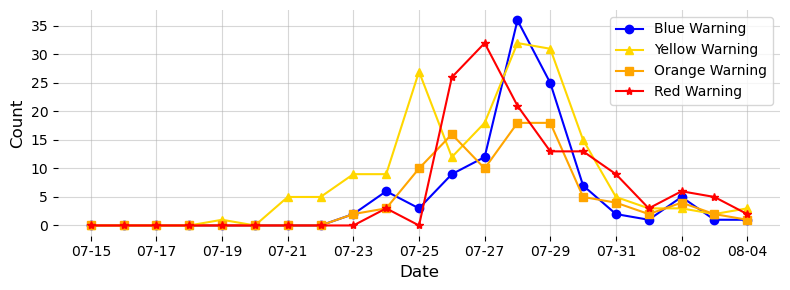

,蓝色预警,黄色预警,橙色预警,红色预警,typhoon,date
0,0,0,0,0,杜苏芮,07-15
1,0,0,0,0,杜苏芮,07-16
2,0,0,0,0,杜苏芮,07-17
3,0,0,0,0,杜苏芮,07-18
4,0,1,0,0,杜苏芮,07-19
5,0,0,0,0,杜苏芮,07-20
6,0,5,0,0,杜苏芮,07-21
7,0,5,0,0,杜苏芮,07-22
8,2,9,2,0,杜苏芮,07-23
9,6,9,3,3,杜苏芮,07-24


In [219]:
def show_plot(typhoon_name='杜苏芮'):
    temp = pd.DataFrame()
    warning_labels = ['蓝色预警', '黄色预警', '橙色预警', '红色预警']
    date = []
    for i in warning_labels:
        data = get_cities_by_date_warning(typhoon_name, i)
        temp[i] = data['city_count'].tolist()
        date = data['month-day'].tolist()
    temp['typhoon'] = typhoon_name
    temp['date'] = date
    show_lines(temp, typhoon_name)

    temp.to_csv('./result/' + typhoon_name + '_预警_城市数量.csv', index=None)
    return temp
    
show_plot('杜苏芮')

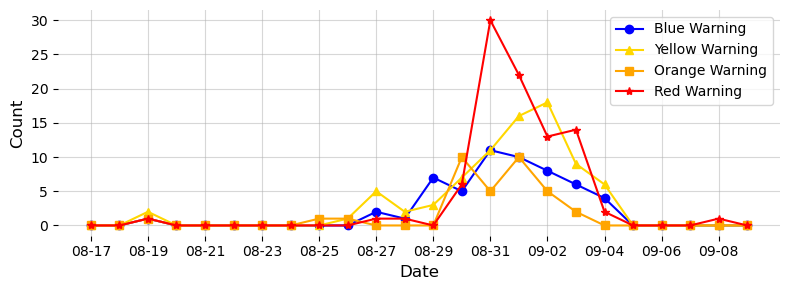

,蓝色预警,黄色预警,橙色预警,红色预警,typhoon,date
0,0,0,0,0,苏拉,08-17
1,0,0,0,0,苏拉,08-18
2,1,2,1,1,苏拉,08-19
3,0,0,0,0,苏拉,08-20
4,0,0,0,0,苏拉,08-21
5,0,0,0,0,苏拉,08-22
6,0,0,0,0,苏拉,08-23
7,0,0,0,0,苏拉,08-24
8,0,0,1,0,苏拉,08-25
9,0,1,1,0,苏拉,08-26


In [220]:
show_plot('苏拉')